In [3]:
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import shap

In [4]:
# Load dataset and create version in dataframe format
xr_data=xr.load_dataset("results_stacked_hh.nc")
df=xr_data.to_dataframe().reset_index()
df['log_z0']=np.log(df['z0'].values)
xr_data

<xarray.Dataset> Size: 191kB
Dimensions:                      (sample: 100, case_index: 182)
Coordinates:
  * sample                       (sample) float64 800B 0.0 1.0 2.0 ... 98.0 99.0
    k_b                          (sample) float64 800B 0.03502 ... 0.04703
    ss_alpha                     (sample) float64 800B 0.9133 1.014 ... 1.225
    wind_farm                    (case_index) <U31 23kB 'HR1' ... 'VirtWF_ABL...
    flow_case                    (case_index) float64 1kB 0.0 1.0 ... 14.0 15.0
Dimensions without coordinates: case_index
Data variables: (12/15)
    power_bias_perc              (sample, case_index) float64 146kB 7.945 ......
    wind_speed                   (case_index) float64 1kB 9.947 9.971 ... 12.97
    wind_direction               (case_index) float64 1kB 14.98 9.983 ... 270.0
    turbulence_intensity         (case_index) float64 1kB 0.0538 ... 0.03155
    potential_temperature        (case_index) float64 1kB 293.2 293.2 ... 293.2
    z0                           (case_index) float32 728B 0.00209 ... 0.0002
    ...                           ...
    capping_inversion_thickness  (case_index) float64 1kB 274.3 232.7 ... 295.1
    turb_rated_power             (case_index) float64 1kB 2e+06 ... 1.5e+07
    nt                           (case_index) int64 1kB 80 80 80 ... 100 100 100
    farm_density                 (case_index) float64 1kB 2.452e+05 ... 1.633...
    Blockage_Ratio               (case_index) float64 1kB 0.1439 ... 0.8986
    Blocking_Distance            (case_index) float64 1kB 1.6e+03 ... 1.852e+03

In [5]:
# in dataframe format
df.head()

,sample,case_index,power_bias_perc,wind_speed,wind_direction,turbulence_intensity,potential_temperature,z0,LMO,ABL_height,...,turb_rated_power,nt,farm_density,k_b,ss_alpha,wind_farm,flow_case,Blockage_Ratio,Blocking_Distance,log_z0
0,0.0,0,7.945468,9.946975,14.983102,0.053803,293.157143,0.002090,100000.0,951.166896,...,2000000.0,80,245159.9375,0.035021,0.913322,HR1,0.0,0.143910,1600.000000,-6.170591
1,0.0,1,8.796825,9.971009,9.983315,0.069163,293.164520,0.020800,100000.0,956.370264,...,2000000.0,80,245159.9375,0.035021,0.913322,HR1,1.0,0.112734,1600.000000,-3.872802
2,0.0,2,32.471102,9.952359,4.983150,0.060814,293.160126,0.006864,100000.0,952.575951,...,2000000.0,80,245159.9375,0.035021,0.913322,HR1,2.0,0.212993,1600.000000,-4.981465
3,0.0,3,67.028585,9.955688,-0.016862,0.057949,293.158852,0.004365,100000.0,951.768487,...,2000000.0,80,245159.9375,0.035021,0.913322,HR1,3.0,0.058441,1538.980201,-5.434137
4,0.0,4,-28.975190,9.950229,-5.016874,0.058088,293.158852,0.004467,100000.0,951.787298,...,2000000.0,80,245159.9375,0.035021,0.913322,HR1,4.0,0.607518,967.997968,-5.411038


## Distribution of target for all samples:
- Hornsrev and nysted wind farm cases seem to have a lower bias
- Significantly higher bias for the Virtual Wind Farm cases with larger rated power, extremely large in many cases

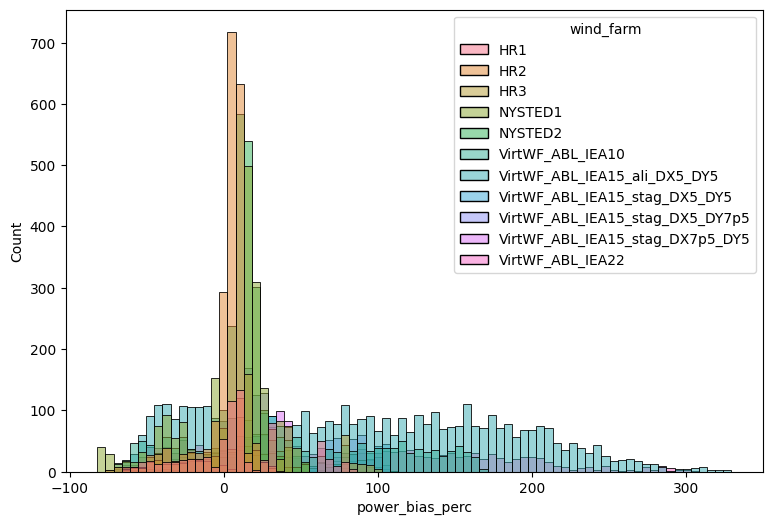

In [6]:
plt.figure(figsize=(9,6))
ax=sns.histplot(df,x="power_bias_perc",hue="wind_farm")

## Relationships between individual features and target variables

/tmp/ipykernel_252550/3288546814.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10", len(unique_labels))  # or use seaborn color_palette


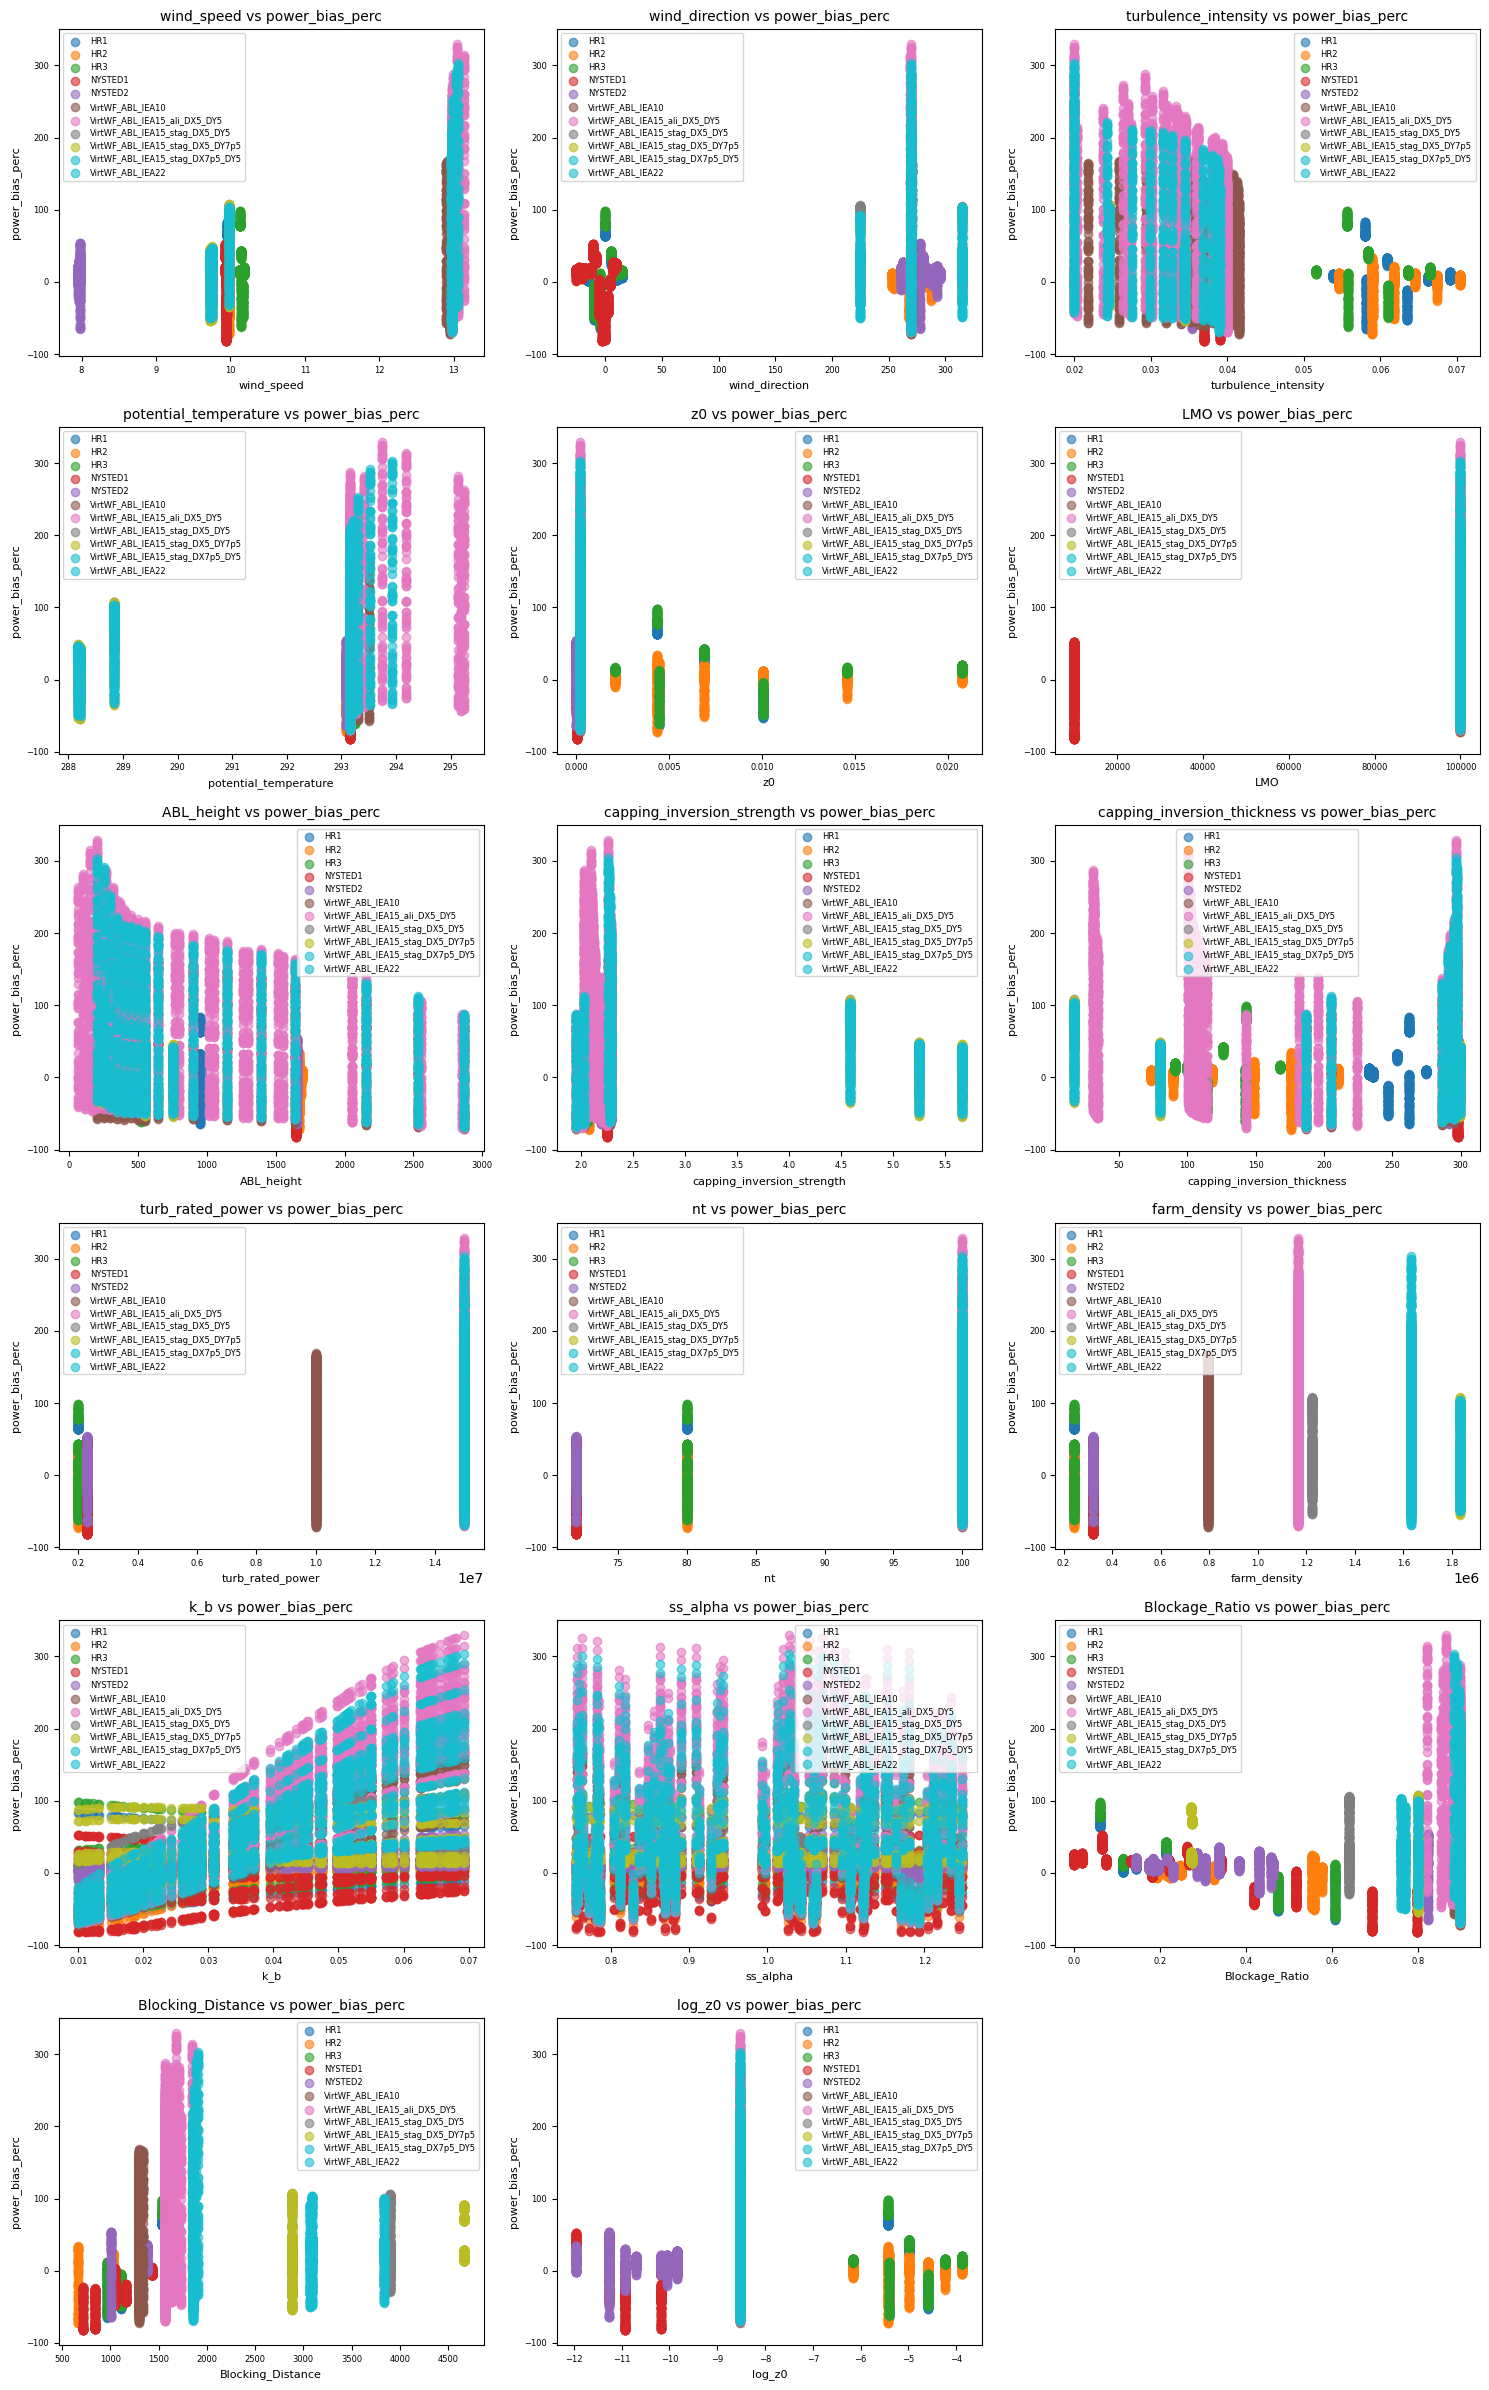

In [7]:
def plot_feature_vs_target(features, target, target_name, hue=None):
    """
    Plots scatter plots of all features against a specified target variable,
    with optional hue-based coloring.

    Parameters:
    - features: DataFrame of features.
    - target: Series of target values.
    - target_name: Label for the target.
    - hue: Optional categorical Series aligned with features/target for coloring.
    """
    n_features = len(features.columns)
    n_cols = 3
    n_rows = (n_features // n_cols) + (n_features % n_cols > 0)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten()

    # Define color palette
    if hue is not None:
        unique_labels = hue.unique()
        palette = plt.cm.get_cmap("tab10", len(unique_labels))  # or use seaborn color_palette
        color_dict = {label: palette(i) for i, label in enumerate(unique_labels)}

    for i, feature in enumerate(features.columns):
        ax = axes[i]
        if hue is None:
            ax.scatter(features[feature], target, alpha=0.6)
        else:
            for label in unique_labels:
                mask = hue == label
                ax.scatter(features[feature][mask], target[mask], 
                           alpha=0.6, label=str(label), color=color_dict[label])
            ax.legend(fontsize=6)

        ax.set_title(f'{feature} vs {target_name}', fontsize=10)
        ax.set_xlabel(feature, fontsize=8)
        ax.set_ylabel(target_name, fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=6)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    
features = df.drop(['wind_farm', 'flow_case','sample', 'case_index','power_bias_perc'], axis=1)
target = df['power_bias_perc']
hue = df['wind_farm']  # or any other categorical variable

plot_feature_vs_target(features, target, 'power_bias_perc', hue=hue)

## Correlation between features

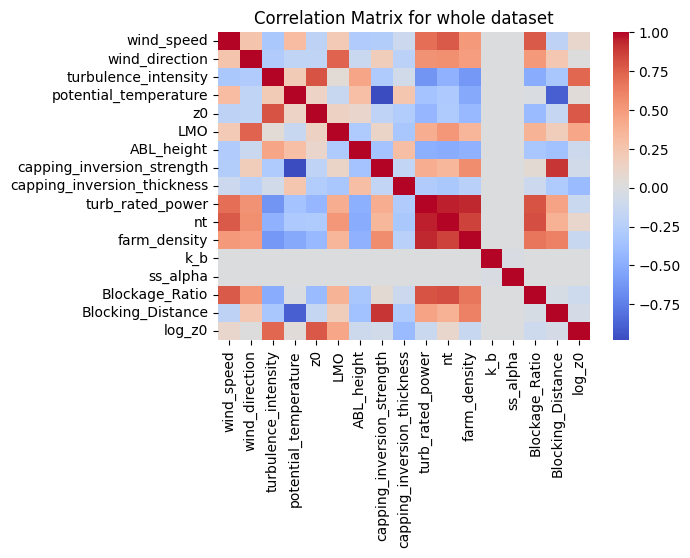

In [8]:
plt.figure(figsize=(6,4))
sns.heatmap(features.corr(),annot=False,cmap='coolwarm')
plt.title(f'Correlation Matrix for whole dataset')
plt.show()

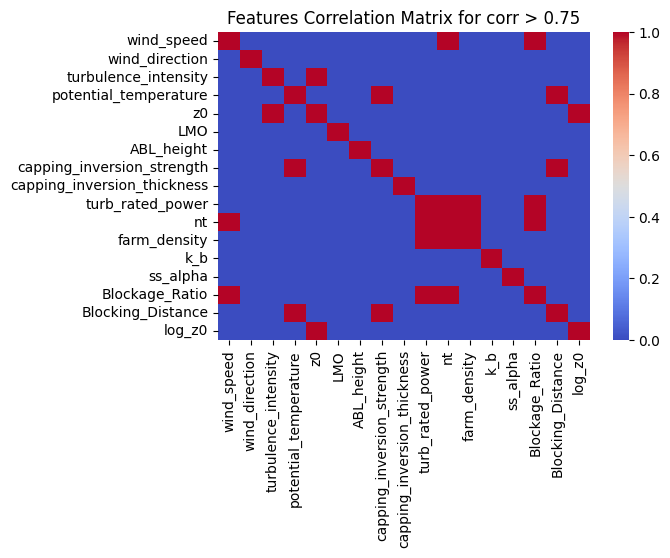

In [9]:
# Seeing whether there are features with a correlation beyond a certain threshold
thresh=0.75
corr_matrix = features.corr()
high_corr = corr_matrix.abs() > thresh

plt.figure(figsize=(6,4))
sns.heatmap(high_corr, annot=False, cmap='coolwarm')
plt.title(f'Features Correlation Matrix for corr > {thresh}')
plt.show()

# Correlation between features and target

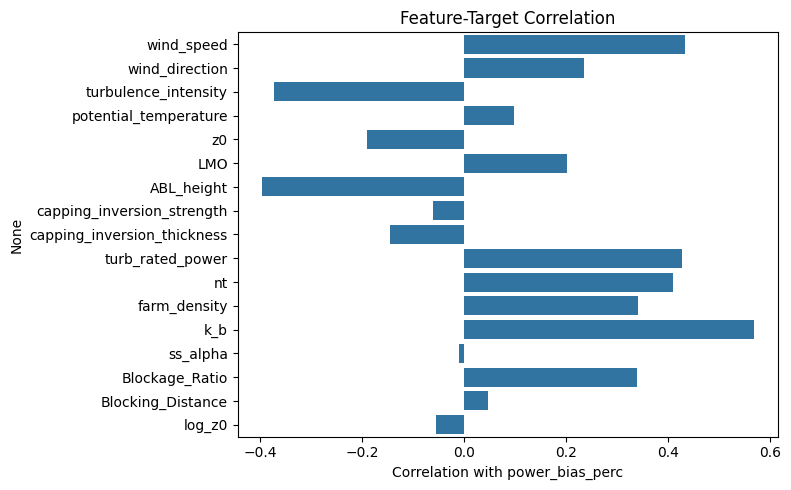

In [10]:
# Compute correlation between each feature and the target
feature_target_corr = features.corrwith(target)
feature_target_corr.sort_values(ascending=False)


plt.figure(figsize=(8,5))
sns.barplot(x=feature_target_corr.values, y=feature_target_corr.index, orient='h')
plt.xlabel('Correlation with power_bias_perc')
plt.title('Feature-Target Correlation')
plt.tight_layout()
plt.show()

# PLotting SHAP Scores from XGBoost in a cross validation loop

In [11]:
# # Train an XGBoost regressor
# model = xgb.XGBRegressor()
# model.fit(features, target)

# # Create SHAP explainer and compute SHAP values
# explainer = shap.Explainer(model, features)
# shap_values = explainer(features)

# # Summary plot of SHAP values
# shap.summary_plot(shap_values, features)

Fold 1/10


 99%|===================| 1796/1820 [01:03<00:00]        

Fold 2/10


 99%|===================| 1810/1820 [01:03<00:00]        

Fold 3/10


 99%|===================| 1810/1820 [01:02<00:00]        

Fold 4/10


 99%|===================| 1798/1820 [01:01<00:00]        

Fold 5/10


 99%|===================| 1800/1820 [01:00<00:00]        

Fold 6/10


100%|===================| 1817/1820 [01:00<00:00]        

Fold 7/10


 99%|===================| 1801/1820 [01:01<00:00]        

Fold 8/10


 99%|===================| 1807/1820 [01:00<00:00]        

Fold 9/10


 99%|===================| 1804/1820 [01:01<00:00]        

Fold 10/10


 99%|===================| 1807/1820 [01:00<00:00]        

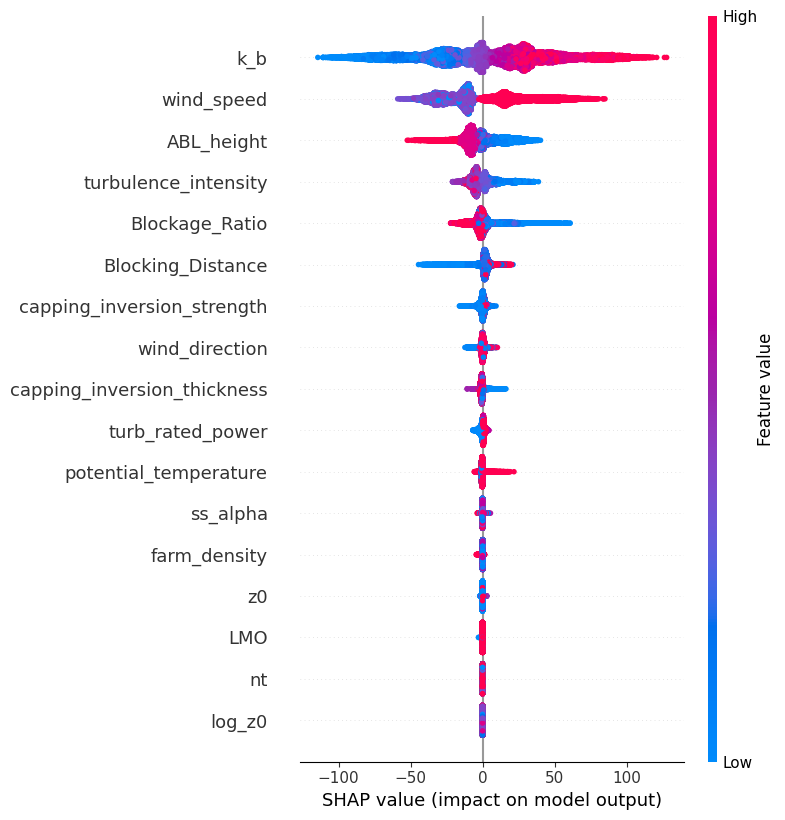

In [12]:
def plot_shap_values_with_kfold(features, targets, feature_names=None, n_splits=10, random_state=15):
    """

    uses k-fold cross validation to train xgboost and aggregates the shap values
    for each fold. Then visualizes shap values for model interpretability

    """
   
   # if scaled_features is not a dataframe, (a numpy array) you need to prove the feature names additionally
    if isinstance(features, np.ndarray):
        if feature_names is None:
            raise ValueError("You must provide feature_names when using ndarray input.")
        X = pd.DataFrame(features, columns=feature_names)
    else:
        X = features.copy()
        feature_names = X.columns.tolist()

    y = targets

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)


    all_shap_values = []
    all_X_test = []
    all_y_test = []
    
    # KFold cross-validation loop
    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        print(f"Fold {fold_idx + 1}/{n_splits}")
        
        X_train_raw, X_test_raw = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit scaler only on training data
        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=feature_names, index=X_train_raw.index)
        X_test = pd.DataFrame(scaler.transform(X_test_raw), columns=feature_names, index=X_test_raw.index)


        model=xgb.XGBRegressor(n_estimators=1024, random_state=random_state)
        model.fit(X_train, y_train)

        explainer = shap.Explainer(model, X_train)

        shap_values = explainer(X_test,check_additivity=False)

        all_shap_values.append(shap_values.values)
        all_X_test.append(X_test)
        all_y_test.append(y_test)
    
    combined_shap_values = np.concatenate(all_shap_values, axis=0)
    combined_X_test = pd.concat(all_X_test, axis=0)
        

    plt.figure()
    shap.summary_plot(combined_shap_values, combined_X_test, feature_names=feature_names, show=True)
        # plt.title(f"{model_name}\n{target[target_index]}")
        # plt.savefig(f'plots/shap/{model_name}_{target_vars[target_index]}.png')

plot_shap_values_with_kfold(features, target)